<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Данные представляют из себя таблицу состоящую из 3 колонок и 159292 строк. Выборка очень большая, поэтому, чтобы немного облегчить задачу и сократить время выполнения кода уменьшим количество строк до 15000

Теперь проверим датасет на пропуски и удалим столбец Unnamed: 0, он не понадобится в процессе обучения.

In [5]:
data.isna().sum() #проверка пропусков

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
data = data.drop('Unnamed: 0',axis=1) #удаляем столбец

В столбце toxic находится целевой признак, в котором указана информация о комментарии, токсичен он или нет. Нам нужно проверить баланс классов для этого столбца. Построим гистограмму и применим метод value_counts, который вернет нам количество значений по каждому классу, чтоб точно знать во сколько раз отличаются классы.

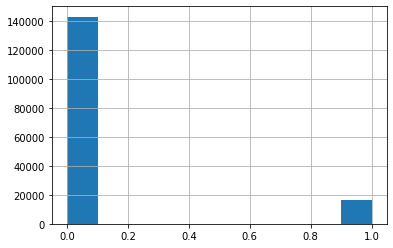

In [7]:
data['toxic'].hist(); #создаем гистограмму

In [8]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Между классами большой дисбаланс, почти в 10 раз отличается количество токсичных комментариев от количества нетоксичных. Для модели очень важен баланс классов, поэтому для уравновешивания к моедлям добавим гиперпараметр balanced. Но сначала подготовим столбец с комментариями к обучению, проведя лемматизацию, очистку текста и переведя слова в векторы.

Сначала напишем 2 функции, одна проведет лемматизацию для каждого комментария, а вторая очистит текст от ненужных нам символов

In [9]:
data['text'] = data['text'].str.lower()

In [10]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in tokenizer.tokenize(text)]
data['text'] = data.text.apply(lemmatize)

In [13]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear_text = clear_text.split()
    clear_text = " ".join(clear_text)
    return clear_text
data['text'] = data['text'].apply(str)
data['text'] = data.text.apply(clear_text)

<font color='purple'><b>Комментарий студента</b></font> Привела)

In [14]:
data['text'].values[:3]

array(['explanation why the edits make under my username hardcore metallica fan be reverted they weren t vandalisms just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now',
       'd aww he match this background colour i m seemingly stuck with thanks talk january utc',
       'hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info'],
      dtype=object)

Теперь разделим данные на 3 выборки, обучающую, валидационную и тестовую, выделим признак, к которум относится столбец с комментариями. Каждый из них закодируем с помощью TF IDF.

In [15]:
train, test = train_test_split(data, test_size=0.1)
train, valid = train_test_split(train, test_size=0.1)

In [16]:
features_train = train['text']
features_valid = valid['text']
features_test = test['text']

In [17]:
vectorizer = TfidfVectorizer()
features_train = vectorizer.fit_transform(features_train)

In [18]:
features_valid = vectorizer.transform(features_valid)
features_test = vectorizer.transform(features_test)

Теперь выделим целевой признак, а заодно проверим верно ли закодирован текст.

In [19]:
target_train = train['toxic']
target_valid = valid['toxic']
target_test = test['toxic']

In [20]:
features_train.shape

(129025, 143984)

In [ ]:
features_valid.shape

## Обучение

Текст подготовлен, можно переходить к обученияю моделей. Их у нас будет три: логистическая регрессия, случайный лес и LGBMClassifier.

### Логистическая регрессия

In [26]:
model_logist = LogisticRegression(class_weight='balanced', C = 10)
model_logist.fit(features_train, target_train)
pred_logist = model_logist.predict(features_valid)
f1_logist = f1_score(target_valid,pred_logist)
print('Значение F1 на валидационной выборке:', f1_logist)

Значение F1 на валидационной выборке: 0.7643312101910829


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Случайный лес

In [23]:
best_model = None
best_result = 0.75
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,class_weight='balanced')
        model_forest.fit(features_train, target_train)
        c
        f1_forest = f1_score(target_valid,pred_forest)
        if f1_forest > best_result:
            best_model = model_forest
            best_result = f1_forest
            best_est = est
            best_depth = depth

print('Значение F1 на валидационной выборке:', best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Значение F1 на валидационной выборке: 0.75 Количество деревьев: 0 Максимальная глубина: 10


### LGBMClassifier

In [24]:
model_lgbm = LGBMClassifier(boosting_type='dart',class_weight='balanced')
model_lgbm.fit(features_train, target_train)
pred_lgbm = model_lgbm.predict(features_valid)
f1_lgbm = f1_score(target_valid,pred_lgbm)
print('Значение F1 на валидационной выборке:', f1_lgbm)

Значение F1 на валидационной выборке: 0.6267872775021885


### Тестирование лучшей модели

In [27]:
pred_test = model_logist.predict(features_test)
f1_test = f1_score(target_test,pred_test)
print('Значение F1 на тестовой выборке:', f1_test)

Значение F1 на тестовой выборке: 0.7604256542996836


## Выводы

Лучшей моделью является модель логистической регрессии, результат F1 на тестовой выборке 0.752, т.е. больше 0.75